# 0. Importing packages

In [ ]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba
import warnings
warnings.simplefilter('always', RuntimeWarning)

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
plt.rcParams.update({'font.size': 10})
# plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434','#3EBCD2','#379A8B','#9A607F', '#B4BA39']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from scipy.interpolate import interp1d

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# 1. Solving for steady state

The model to be solved can be written as:
$$
\textbf{F}_t(\textbf{X}, Z) \equiv 
\begin{pmatrix}
Y_t - Z_t N_t
\\
Y_t \left[1 - \frac{\mu}{\mu-1}\frac{1}{2\kappa} \log(1 + \pi_t)^2\right] - w_t N_t - d_t
\\
r_t B - \tau_t
\\
r^*_t + \phi \pi_t - i_t
\\
1 + r_t - \frac{1+i_{t-1}}{1+\pi_t}
\\
\kappa \left(\frac{w_t}{Z_t} - \frac{1}{\mu} \right)  + \frac{1}{1+r_{t+1}} \frac{Y_{t+1}}{Y_t} \log(1+\pi_{t+1}) - \log(1+\pi_t)
\\
\mathcal{B}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{B}
\\
\mathcal{H}_t(\{r_s, w_s, \tau_s, d_s, q^h_s\})  - \bar{H}
\\
\varphi N_t^{\nu} \frac{1}{\theta}\left(C_{t}^\theta H_t^{1-\theta}\right)^\sigma\left(\frac{C_{t}}{H_t}\right)^{1-\theta} - w_t
\end{pmatrix}
= \begin{pmatrix} 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0 \\ 0\end{pmatrix},
\quad t = 0, 1, \dots
$$

## 1.1. Household/HA block

Let's first construct our household/HA block to be used for both the steady state DAG and the transition DAG 

In [ ]:
# load the HA block
hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])
# hh1 = hh1.add_hetoutputs([utils.compute_weighted_mpc])

print(f'Inputs: {hh1.inputs}')
print(f'Macro outputs: {hh1.outputs}')
print(f'Micro outputs: {hh1.internals}')

## 1.2. Other blocks for steady state

Now the other blocks for the model can be defined

In [ ]:
@simple
def firm(N, w, Z, pi, mu, kappa):
    # N = Y / Z
    Y = Z * N
    Div = Y - w * N - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y
    return Y, Div

@simple
def monetary(pi, rstar, phi):
    # r = (1 + rstar(-1) + phi * pi(-1)) / (1 + pi) - 1
    r = (1 + rstar(-1) + phi * pi(-1)) - pi - 1
    return r

@simple
def fiscal(r, BBAR):
    Tax = r * BBAR
    return Tax

@simple
def wage_res(C_BHAT, H_BHAT, N, varphi, nu, theta, sigma, w):
    wage_res = varphi * N ** nu * 1 / theta * (C_BHAT**theta*H_BHAT**(1-theta))**sigma * (C_BHAT/H_BHAT)**(1-theta) - w
    return wage_res

@simple
def mkt_clearing(B_BHAT, C_BHAT, Y, BBAR, pi, mu, kappa, HBAR, H_BHAT, CHI, qh, gamma):
    asset_mkt = BBAR + gamma*qh*H_BHAT - B_BHAT
    goods_mkt = Y - C_BHAT - mu/(mu-1)/(2*kappa) * (1+pi).apply(np.log)**2 * Y - CHI
    house_mkt = HBAR - H_BHAT
    return asset_mkt, goods_mkt, house_mkt

@simple 
def qhouse_lag(qh):
    qh_lag = qh(-1)
    return qh_lag

@simple
def nkpc_ss(Z, mu):
    w = Z / mu
    return w

## 1.3. Creating the model and solving for steady state

In [ ]:
blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]

hank_ss = create_model(blocks_ss, name="One-Asset HANK SS")

print(hank_ss)
print(f"Inputs: {hank_ss.inputs}")
print(f"Outputs: {hank_ss.outputs}")

In [ ]:
calibration = {'gamma': 0.8, 'theta': 0.89, 'sigma': 2.5, 'alpha': 2.0, 'bmax': 50,
               'hmax': 5.0, 'kmax': 1, 'nB': 60, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.0, 'HBAR': 1.0}

calibration['theta'] = 0.96
# calibration['theta'] = 0.97
# calibration['BBAR'] = 1.0

# Calibrated parameters: beta (for goods market clearing), qh (for house market clearing), phi (for the wage schedule), w (for the Philips curve)
# unknowns_ss = {'beta': 0.986, 'varphi': 0.8, 'qh': 5.0}
unknowns_ss = {'beta': 0.937266818342156, 'varphi': 0.8025483962473203, 'qh': 5.99193013178212}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(calibration, unknowns_ss, targets_ss, solver="hybr")
ss =  hank_ss.steady_state(ss0)

In [ ]:
print(ss['beta'], ss['varphi'], ss['qh'])

In [ ]:
# solve for steady state in a low leverage economy with gamma = 0.4
calibration_lowlev = calibration.copy()
calibration_lowlev['gamma'] = 0.2
# calibration_lowlev['BBAR'] = 0.4

unknowns_ss = {'beta': 0.937266818342156, 'varphi': 0.8025483962473203, 'qh': 5.99193013178212}
ss_ll = hank_ss.solve_steady_state(calibration_lowlev, unknowns_ss, targets_ss, solver="hybr")

### 1.3.1. Printing and comparing steady state results

In [ ]:
from tabulate import tabulate

table_data = [
    ["Variable", "High leverage (gamma = 0.8)", "Low leverage (gamma = 0.2)"],
    ["Asset market clearing (untargeted)", f"{ss['asset_mkt']: 0.2e}", f"{ss_ll['asset_mkt']: 0.2e}"],
    ["Goods market clearing", f"{ss['goods_mkt']: 0.2e}", f"{ss_ll['goods_mkt']: 0.2e}"],
    ["Housing market clearing", f"{ss['house_mkt']: 0.2e}", f"{ss_ll['house_mkt']: 0.2e}"],
    ["Wage schedule residual", f"{ss['wage_res']: 0.2e}", f"{ss_ll['wage_res']: 0.2e}"],
    ["beta", ss['beta'], ss_ll['beta']],
    ["qh", ss['qh'], ss_ll['qh']],
    ["wage", ss['w'], ss_ll['w']],
    ["varphi", ss['varphi'], ss_ll['varphi']],
    ["Housing wealth, qh*H/(4*Y)", ss['H_BHAT']*ss['qh']/(4*ss['Y']), ss_ll['H_BHAT']*ss_ll['qh']/(4*ss_ll['Y'])],
    ["B_BHAT - qh*H_BHAT*gamma", ss['B_BHAT'] - ss['qh']*ss['H_BHAT']*ss['gamma'], ss_ll['B_BHAT'] - ss_ll['qh']*ss_ll['H_BHAT']*ss_ll['gamma']],
    ["Leverage, bhat/(4*Y)", ss['B_BHAT']/(4*ss['Y']), ss_ll['B_BHAT']/(4*ss_ll['Y'])],
    ["Chi", ss['CHI'], ss_ll['CHI']],
    ["Consumption", ss['C_BHAT'], ss_ll['C_BHAT']],
]

print(tabulate(table_data, headers="firstrow", tablefmt="grid"))

## 1.3.2. Plotting the steady state policy functions

In [ ]:
fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

z_point = 0
for i_h in range(0, calibration['nH'], 10):
    ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['c_bhat'][z_point,:, i_h], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['b_bhat'][z_point,:, i_h])

ax.legend()
ax.set_title('Consumption')
ax2.set_title('Housing')
ax3.set_title('Bond holdings')
fig.suptitle('Steady state policy functions', fontsize=14)
ax3.set_xlim([-0.01, 0.5])
ax3.set_ylim([0, 0.2])

plt.show()

Get the policy function for bond holdings

In [ ]:
# low_inc_dist = ss.internals['hh_housecons']['D'][0,:,:]
# b_dist = low_inc_dist - 
z_point = 0
b_point = 5
h_point = 5

b_endo = ss.internals['hh_housecons']['b_bhat_grid'][None,:] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat_grid'][:,None]
b_polfunc = ss.internals['hh_housecons']['b_bhat'] - ss['gamma'] * ss['qh'] * ss.internals['hh_housecons']['h_bhat']
leverage_polfunc = -b_polfunc / (ss['qh'] * ss.internals['hh_housecons']['h_bhat'])

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for iH in range(0, calibration['nH'], 2):
    ax.plot(b_endo[iH,:], b_polfunc[z_point,:, iH], label=f'h = {ss.internals["hh_housecons"]["h_bhat_grid"][iH]:.2f}')

# ax.plot(b_endo[h_point,:], b_polfunc[z_point,:, h_point])
ax.set_xlim(-2, 0.5)
ax.set_ylim(-10, 0.5)

# plot 2: leverage ratio
for iB in range(0, calibration['nB']-50):
    ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], leverage_polfunc[z_point,:, iB])

ax2.set_ylim(-1.0, ss['gamma'])
ax2.set_title('Optimal leverage ratio')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel(r'$b / q^h h$')
plt.show()

## 1.4. Plotting the steady state distributions

### 1.4.1. Housing and bond holdings

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
bdmargdist = np.sum(ss.internals['hh_housecons']['D'],axis=0)
X, Y = np.meshgrid(ss.internals['hh_housecons']['h_bhat_grid'],ss.internals['hh_housecons']['b_bhat_grid'])
b_margdist = np.sum(bdmargdist,axis=1) # sum out housing
bmargcum = np.cumsum(b_margdist)

# print(bdmargdist.shape)
# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, bdmargdist, cmap='viridis')
# ax.set_xlim(0, 3)
# ax.set_ylim(0, 20)

In [ ]:
# getting the marginal distribution of bond holdings for low leverage economy
bdmargdist_ll = np.sum(ss_ll.internals['hh_housecons']['D'],axis=0)
b_margdist_ll = np.sum(bdmargdist_ll,axis=1) # sum out housing
bmargcum_ll = np.cumsum(b_margdist_ll)

mpc, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')
mpc_ll, mean_mpc_ll = utils.calc_mpc(ss_ll, 'hh_housecons')

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

# plot 1: marginal distribution of bond holdings across leverage ratios
ax.plot(ss.internals['hh_housecons']['b_bhat_grid'], bmargcum, label = 'High leverage')
ax.plot(ss_ll.internals['hh_housecons']['b_bhat_grid'], bmargcum_ll, label = 'Low leverage')
ax.set_title('Cumulative distribution of bond holdings')
ax.legend()

# plot 2: MPCs across leverage ratios
h_idx = 20
ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],mpc[1,:-1,h_idx])
ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],mpc_ll[1,:-1,h_idx])
ax2.text(0.5, 0.95, f'High leverage avg. MPC {mean_mpc:.2f}', horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)
ax2.text(0.5, 0.9, f'Low leverage avg. MPC {mean_mpc_ll:.2f}', horizontalalignment='left', verticalalignment='top', transform=ax2.transAxes)
ax2.set_title('Marginal propensity to consume')
ax2.set_xlabel('Bond holdings')
ax2.set_ylabel('MPC')

plt.show()


In [ ]:
z_point = 1
h_point = 66

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

for i_h in range(0, calibration['nB'], 1):
    if i_h%2 == 0:
        # ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :])
        pass
    else:
        ax.plot(ss.internals['hh_housecons']['h_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, i_h, :], ls = '--')

for i_h in range(0, calibration['nH'], 1):
    if i_h%2 == 0:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h])
    else:
        ax2.plot(ss.internals['hh_housecons']['b_bhat_grid'], ss.internals['hh_housecons']['D'][z_point, :, i_h], ls = '--')

ax.set_title('Housing wealth')
ax2.set_title('Bond holdings')

plt.show()

### 1.4.2. MPCs

In [ ]:
# # MPC
# MPC = np.zeros(ss.internals['hh_housecons']['D'].shape)
# dc = (ss.internals['hh_housecons']['c_bhat'][:,1:,:]-ss.internals['hh_housecons']['c_bhat'][:,:-1,:])
# dm = (1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,1:,np.newaxis]-(1+ss['r'])*ss.internals['hh_housecons']['b_bhat_grid'][np.newaxis,:-1,np.newaxis]
# MPC[:,:-1,:] = dc/dm
# MPC[:,-1,:] = MPC[:,-1,:] # assuming constant MPC at end
# mean_MPC = np.sum(MPC*ss.internals['hh_housecons']['D'])

MPC, mean_mpc = utils.calc_mpc(ss, 'hh_housecons')

h_point = 1
print(f'mean MPC: {mean_mpc:.3f}')
fig, ax = plt.subplots()
ax.plot(ss.internals['hh_housecons']['b_bhat_grid'][:-1],MPC[1,:-1,h_point])
plt.show()

## 1.5. Solving model with seperability between housing and consumption

In [ ]:
# load the HA block and add inputs
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]
hank_ss_sep = create_model(blocks_ss, name="One-Asset HANK SS")

calibration2 = {'gamma': 0.8, 'theta': 0.03, 'sigma': 1.0, 'alpha': 1.0, 'bmax': 45,
               'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
               'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 0.15, 'HBAR': 1.0}

unknowns_ss = {'beta': 0.986, 'varphi': 0.08345079332201338, 'qh': 8.845303164603399}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0_sep = hank_ss_sep.solve_steady_state(calibration2, unknowns_ss, targets_ss, solver="hybr")
ss_sep =  hank_ss_sep.steady_state(ss0_sep)

print(f"beta: {ss_sep['beta']}")
print(f"varphi: {ss_sep['varphi']}")
print(f"SS qh: {ss_sep['qh']}")
print(f"qh*H/(4*Y): {ss_sep['H_BHAT']*ss_sep['qh']/(4*ss_sep['Y'])}")
print(f"Leverage: {ss_sep['B_BHAT']/(ss_sep['Y'])}")

In [ ]:
# calculate the endogenous grid for the bond holdings
b_endo = ss_sep.internals['hh_housecons_sep']['b_bhat_grid'][None,:] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat_grid'][:,None]

# calculate the policy function for the bond holdings and leverage ratio
b_polfunc = ss_sep.internals['hh_housecons_sep']['b_bhat'] - ss_sep['gamma'] * ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat']
leverage_polfunc = -b_polfunc / (ss_sep['qh'] * ss_sep.internals['hh_housecons_sep']['h_bhat'])

### 1.6.1. Getting the distribution and MPC

In [ ]:
# average MPC
mpc, mean_mpc = utils.calc_mpc(ss_sep, 'hh_housecons_sep')
print(f'mean MPC: {mean_mpc:.3f}')

### 1.6.2. Plotting a dashboard 

In [ ]:
z_point = 0

# creating a plotting dashboard
fig = plt.figure(figsize=(18, 10))
ax = fig.add_subplot(2,3,1)
ax2 = fig.add_subplot(2,3,2)
ax3 = fig.add_subplot(2,3,3)
ax4 = fig.add_subplot(2,3,4)
ax5 = fig.add_subplot(2,3,5)
ax6 = fig.add_subplot(2,3,6)

for i_h in range(0, calibration2['nH'], 10):
    ax.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
            ss_sep.internals['hh_housecons_sep']['c_bhat'][z_point,:, i_h], label=f'h = {ss_sep.internals["hh_housecons_sep"]["h_bhat_grid"][i_h]:.2f}')
    ax2.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['h_bhat'][z_point,:, i_h])
    ax3.plot(ss_sep.internals['hh_housecons_sep']['b_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['b_bhat'][z_point,:, i_h])
    
for i_b in range(0, calibration2['nB'], 6):
    ax4.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], 
             ss_sep.internals['hh_housecons_sep']['c_bhat'][z_point, i_b, :], 
             label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')
    
for iB in range(0, calibration2['nB'], 4):
    ax5.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], leverage_polfunc[z_point, iB, :], 
             label=fr'$\hat b$ = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][iB]:.1f}')

for iH in range(0, calibration2['nH'], 2):
    ax6.plot(b_endo[iH,:], leverage_polfunc[z_point, :, iH])

ax.set_title('Consumption')
ax.set_xlabel(r'$\hat b$')
ax.legend(fontsize=8, ncol=3)

ax2.set_title('Housing')
ax2.set_xlabel(r'$\hat b$')

ax3.set_xlabel(r'$\hat b$')
ax3.set_title('Next-period bond holdings')

ax4.set_xlabel('Housing')
ax4.set_title('Consumption as a function of housing')

ax5.set_ylim(0.0, ss_sep['gamma']*1.1)
ax5.set_xlim(-0.01, 2.0)
ax5.set_title('Optimal leverage ratio')
ax5.set_xlabel('Housing')
ax5.set_ylabel(r'Leverage $(b / q^h h)$')
# ax5.axhline(ss_sep['gamma'], linestyle='--', color='blue', linewidth=2.5, alpha=0.5)
ax5.legend(ncols = 3, fontsize=8)

ax6.set_ylim(0.0, ss_sep['gamma']*1.1)
ax6.set_xlim(None, 2.0)
ax6.set_title('Optimal leverage ratio')
ax6.set_ylabel(r'Leverage $(b / q^h h)$')
ax6.set_xlabel('Bond holdings')

plt.show()

In [ ]:
z_point = 1
h_point = 66

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1,2,1)
# ax2 = fig.add_subplot(1,2,2)

for i_b in range(0, calibration2['nB']-20, 2):
    if i_b%2 == 0:
        ax.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], ss_sep.internals['hh_housecons_sep']['D'][z_point, i_b, :], label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')
    else:
        ax.plot(ss_sep.internals['hh_housecons_sep']['h_bhat_grid'], ss_sep.internals['hh_housecons_sep']['D'][z_point, i_b, :], ls = '--', label=f'b = {ss_sep.internals["hh_housecons_sep"]["b_bhat_grid"][i_b]:.2f}')

ax.set_title('Housing wealth')
ax.set_xlabel('Housing')
ax.legend(fontsize = 8, ncols = 3)
ax.set_xlim(0.0, 1.0)

ax2.set_title('Bond holdings')
plt.show()

# 2. Transitional dynamics

## 2.1. Building the DAG for transitional dynamics

Have to do a sligth modification of the DAG for transitional dyanmics, because the `nkpc_ss` block is not valid for anything but steady state

In [79]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc, qhouse_lag]
hank = create_model(blocks, name="Housing HANK")

Checking that the steady state DAG created above is valid

In [80]:
ss = hank.steady_state(ss0)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

In [81]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

<JacobianDict outputs=['pi', 'w', 'N', 'qh', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'Y', 'Div', 'r', 'Tax', 'wage_res', 'asset_mkt', 'goods_mkt', 'house_mkt', 'nkpc_res', 'qh_lag'], inputs=['rstar', 'Z']>


### 2.1.1. Plotting the DAG for the model

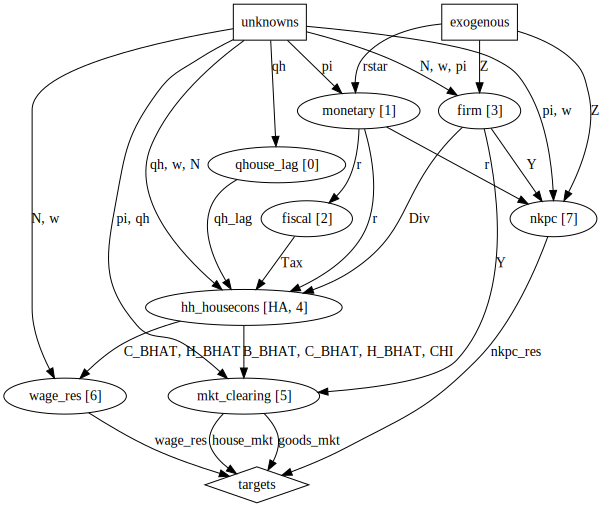

In [82]:
from sequence_jacobian import drawdag
inputs = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

drawdag(hank, inputs, unknowns, targets)

## 2.2. Computing impulse-response functions

### 2.2.1. Computing the non-linear impulse-response functions

In [76]:
# setup
T = 300
exogenous = ['rstar', 'Z', 'gamma']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# construct the shock path for rstar
rho_r, sig_r = 0.8, 0.01
rho_gamma, sig_gamma = 0.8, 0.1
ss_lowleverage = hank.steady_state(ss_ll)
rstar_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
gamma_path = {"gamma": sig_gamma * rho_gamma ** (np.arange(T))}

control = {"gamma": sig_gamma * rho_gamma ** (np.arange(T))}
shock = {"rstar": sig_r * rho_r ** (np.arange(T)), "gamma": sig_gamma * rho_gamma ** (np.arange(T))}
shock_nogam = {"rstar": sig_r * rho_r ** (np.arange(T))}

# compute nonlinear impulse responses
# td_nonlin_control = hank.solve_impulse_nonlinear(ss, unknowns, targets, control)
# td_nonlin_shock = hank.solve_impulse_nonlinear(ss, unknowns, targets, shock)

# td_nonlin_shock_nogam = hank.solve_impulse_nonlinear(ss, unknowns, targets, shock_nogam)

# # compute nonlinear impulse responses
td_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_path)
td_nonlin_ll = hank.solve_impulse_nonlinear(ss_lowleverage, unknowns, targets, rstar_path)

Solving Housing HANK for ['pi', 'w', 'N', 'qh'] to hit ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']
On iteration 0
   max error for nkpc_res is 0.00E+00
   max error for goods_mkt is 6.35E-03
   max error for wage_res is 2.95E-02
   max error for house_mkt is 1.86E-01
On iteration 1
   max error for nkpc_res is 5.27E-05
   max error for goods_mkt is 5.04E-03
   max error for wage_res is 3.32E-03
   max error for house_mkt is 2.92E-02
On iteration 2
   max error for nkpc_res is 3.67E-05
   max error for goods_mkt is 2.50E-03
   max error for wage_res is 1.50E-03
   max error for house_mkt is 7.83E-03
On iteration 3
   max error for nkpc_res is 1.36E-06
   max error for goods_mkt is 2.34E-05
   max error for wage_res is 1.83E-05
   max error for house_mkt is 1.01E-04
On iteration 4
   max error for nkpc_res is 4.43E-08
   max error for goods_mkt is 1.73E-06
   max error for wage_res is 2.25E-07
   max error for house_mkt is 3.34E-07
On iteration 5
   max error for nkpc_res is 1.01E

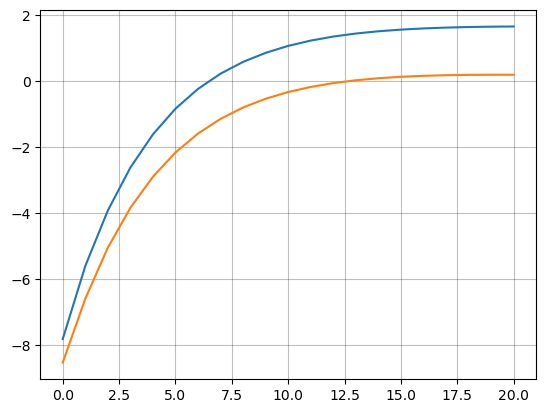

In [75]:
irfs_shock_control = td_nonlin_shock['qh'] - td_nonlin_control['qh']
ifrs_shock_nogam = td_nonlin_shock_nogam['qh']

plt.plot(100*irfs_shock_control[:21])
plt.plot(100*ifrs_shock_nogam[:21])
# plt.plot(td_nonlin_shock['C_BHAT'][:21])
# plt.plot(td_nonlin_control['C_BHAT'][:21])

2 3


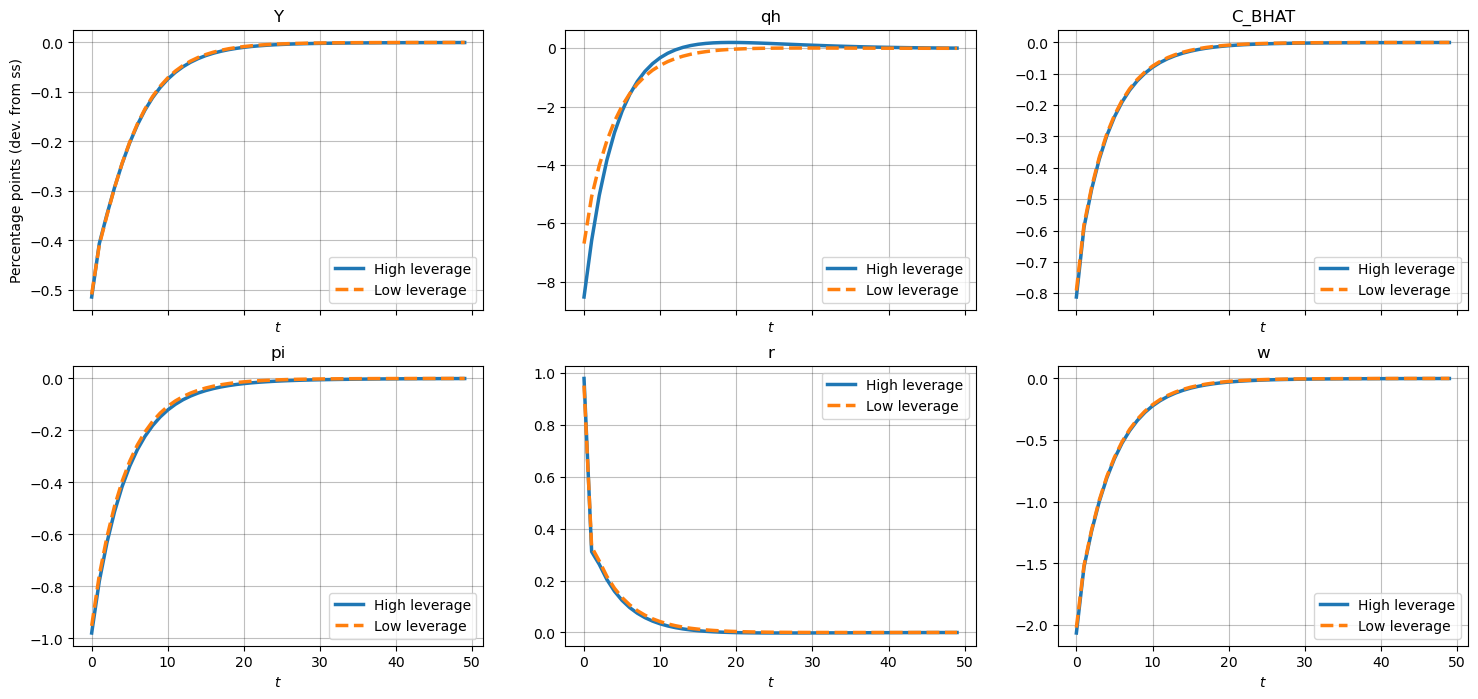

In [78]:
utils.show_irfs([td_nonlin, td_nonlin_ll], ['Y', 'qh', 'C_BHAT', 
                                            'pi', 'r', 'w'], labels=["High leverage", "Low leverage"], figsize=(18,8))

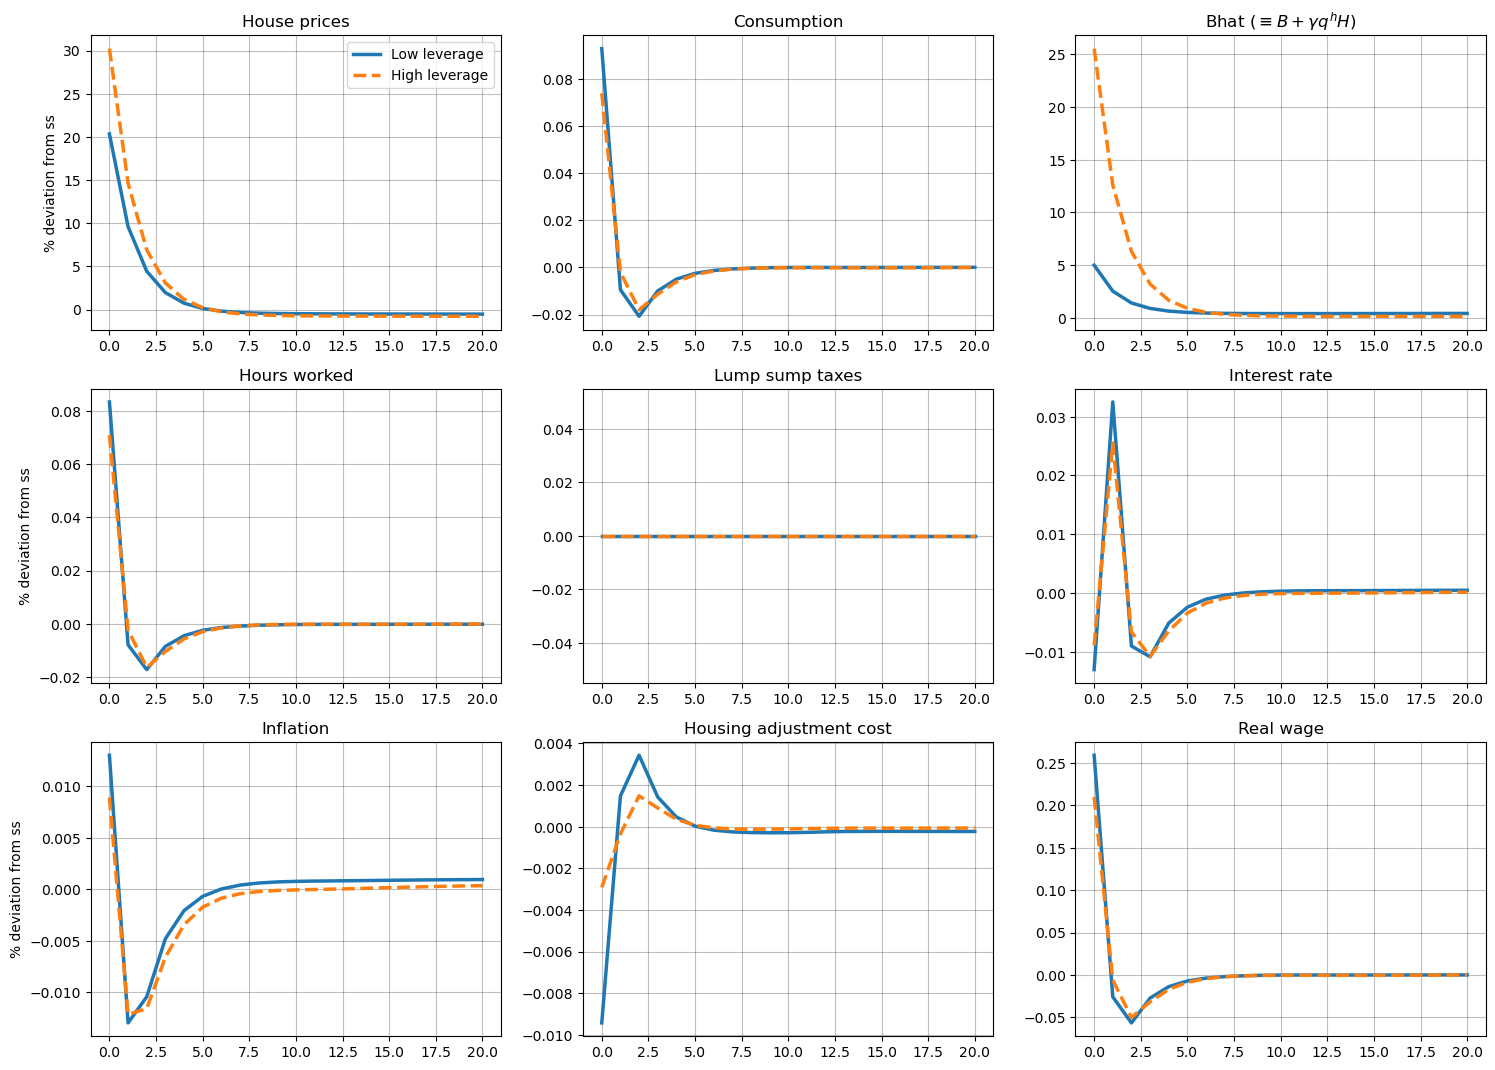

In [41]:
fig = plt.figure(figsize=(18, 13))
ax = fig.add_subplot(3,3,1)
ax2 = fig.add_subplot(3,3,2)
ax3 = fig.add_subplot(3,3,3)
ax4 = fig.add_subplot(3,3,4)
ax5 = fig.add_subplot(3,3,5)
ax6 = fig.add_subplot(3,3,6)
ax7 = fig.add_subplot(3,3,7)
ax8 = fig.add_subplot(3,3,8)
ax9 = fig.add_subplot(3,3,9)

dqh_ll = 100 * td_nonlin_ll['qh']
dqh = 100 * td_nonlin['qh']

dc_ll = 100 * td_nonlin_ll['C_BHAT']
dc = 100 * td_nonlin['C_BHAT']

dN_ll = 100 * td_nonlin_ll['N']
dN = 100 * td_nonlin['N']

dB_ll = 100 * td_nonlin_ll['B_BHAT']
dB = 100 * td_nonlin['B_BHAT']

dTax_ll = 100 * td_nonlin_ll['Tax']
dTax = 100 * td_nonlin['Tax']

dr_ll = 100 * td_nonlin_ll['r']
dr = 100 * td_nonlin['r']

dpi_ll = 100 * td_nonlin_ll['pi']
dpi = 100 * td_nonlin['pi']

dChi_ll = 100 * td_nonlin_ll['CHI']
dChi = 100 * td_nonlin['CHI']

dw_ll = 100 * td_nonlin_ll['w']
dw = 100 * td_nonlin['w']

ax.plot(dqh_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax.plot(dqh[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax.legend()
ax.set_title('House prices')
ax.set_ylabel('% deviation from ss')

ax2.plot(dc_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax2.plot(dc[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax2.set_title('Consumption')

ax3.plot(dB_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax3.plot(dB[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax3.set_title(r'Bhat ($\equiv B + \gamma q^h H$)')

ax4.plot(dN_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax4.plot(dN[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax4.set_title(r'Hours worked')
ax4.set_ylabel('% deviation from ss')

ax5.plot(dTax_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax5.plot(dTax[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax5.set_title(r'Lump sump taxes')

ax6.plot(dr_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax6.plot(dr[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax6.set_title(r'Interest rate')

ax7.plot(dpi_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax7.plot(dpi[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax7.set_title(r'Inflation')
ax7.set_ylabel('% deviation from ss')

ax8.plot(dChi_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax8.plot(dChi[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax8.set_title(r'Housing adjustment cost')

ax9.plot(dw_ll[:21], label='Low leverage', linestyle='-', linewidth=2.5)
ax9.plot(dw[:21], label='High leverage', linestyle='--', linewidth=2.5)
ax9.set_title(r'Real wage')

plt.show()

# 3. Comparing monetary policy under different leverage levels

Computing the steady state of an economy with a leverage of $\gamma = 0.3$ and $\gamma = 0.8$.

In [ ]:
# load the HA block and add inputs
hh = hh_housing_v3.hh_housecons_sep
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

blocks_ss = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc_ss, qhouse_lag]
hank_ss_sep = create_model(blocks_ss, name="One-Asset HANK SS")

cali_lowleverage = {'gamma': 0.35, 'theta': 0.1, 'sigma': 1.0, 'alpha': 0.3, 'bmax': 45,
                    'hmax': 5.0, 'kmax': 1, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3,
                    'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                    'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 5.6, 'HBAR': 1.0}

cali_highleverage = cali_lowleverage.copy()
cali_highleverage['gamma'] = 0.8

unknowns_ss = {'beta': 0.986, 'varphi': 0.08345079332201338, 'qh': 8.845303164603399}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

calib_lowleverage = hank_ss_sep.solve_steady_state(cali_lowleverage, unknowns_ss, targets_ss, solver="hybr")
ss_lowleverage =  hank_ss_sep.steady_state(calib_lowleverage)

calib_highleverage = hank_ss_sep.solve_steady_state(cali_highleverage, unknowns_ss, targets_ss, solver="hybr")
ss_highleverage =  hank_ss_sep.steady_state(calib_highleverage)

Computing the transitional dyanmics in each of the two series

In [ ]:
@simple
def nkpc(pi, w, Z, Y, r, mu, kappa):
    nkpc_res = kappa * (w / Z - 1 / mu) + Y(+1) / Y * (1 + pi(+1)).apply(np.log) / (1 + r(+1))\
               - (1 + pi).apply(np.log)
    return nkpc_res

blocks = [hh1, firm, monetary, fiscal, wage_res, mkt_clearing, nkpc, qhouse_lag]
hank = create_model(blocks, name="Housing HANK")

In [ ]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
# G_lowleverage = hank.solve_jacobian(ss_lowleverage, unknowns, targets, exogenous, T=T)
# G_highleverage = hank.solve_jacobian(ss_highleverage, unknowns, targets, exogenous, T=T)

In [ ]:
rho_r, sig_r = 0.75, 0.01
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
irf_lowleverage = hank.solve_impulse_linear(ss_lowleverage, unknowns, targets, rstar_shock_path)
irf_highleverage = hank.solve_impulse_linear(ss_highleverage, unknowns, targets, rstar_shock_path)

In [ ]:
plt.plot(irf_lowleverage['asset_mkt'][:21], label='Low leverage', linestyle='-', linewidth=2.5)
plt.plot(irf_highleverage['asset_mkt'][:21], label='High leverage', linestyle='--', linewidth=2.5)
plt.legend()
plt.show()

# Appendix A. Debugging the policy functions

## A.1. Setting up the same calibration as for general equilibrium

In [ ]:
import warnings
warnings.simplefilter('always', RuntimeWarning)

b_bhat_grid, h_bhat_grid, k_grid, e_grid, Pi, b_grid = utils.make_grids(bmax, hmax, kmax, nB, nH, nK, nZ, rho_z, sigma_z, gamma, qh_lag)
z_grid = utils.income(e_grid, tax, w, N)

# use backward induction to solve for the steady state policy functions
Vh_p, Vb_p, h_bhat, b_bhat, c_bhat, _ = utils.policy_ss(Pi, h_bhat_grid, b_bhat_grid, z_grid, e_grid, k_grid, beta, 
                                         gamma, theta, sigma, qh, qh_lag, r, alpha, tol=1E-8, max_iter=5_000, debug = False)

c, h, b, b_endo = utils.bhat_to_b(h_bhat_grid, b_bhat_grid, b_grid, z_grid, c_bhat, h_bhat, gamma, alpha, r, qh, qh_lag)

# Appendix B. Old figures

## B.1. Plotting the response for different persistence

In [ ]:
# setup
T = 300
exogenous = ['rstar', 'Z']
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'goods_mkt', 'wage_res', 'house_mkt']

# general equilibrium jacobians
G = hank.solve_jacobian(ss, unknowns, targets, exogenous, T=T)

print(G)

fig = plt.figure(figsize=(18, 4))
ax = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

rhos = np.array([0.2, 0.4, 0.6, 0.8, 0.9])

drstar = -0.0025 * rhos ** (np.arange(T)[:, np.newaxis])
dpi = G['pi']['rstar'] @ drstar
dqh = G['qh']['rstar'] @ drstar
dN = G['C_BHAT']['rstar'] @ drstar
ax.plot(10000 * dpi[:21])
ax.set_title('Inflation')
ax.set_xlabel('quarters')
ax.set_ylabel('bp deviation from ss')
ax.legend([f'rho = {rho}' for rho in rhos])

ax2.plot(10000 * dqh[:21])
ax2.set_title('House prices')
ax2.set_xlabel('quarters')
ax2.set_ylabel('bp deviation from ss')

ax3.plot(10000 * dN[:21])
ax3.set_title('Consumption')
ax3.set_xlabel('quarters')
ax3.set_ylabel('bp deviation from ss')

plt.show()

qh_lag_level = G['qh']['rstar'] @ drstar + ss['qh']
B_BHAT_level = G['B_BHAT']['rstar'] @ drstar + ss['B_BHAT']
B_level = B_BHAT_level - ss['gamma']*qh_lag_level*ss['H_BHAT']
leverage = B_level/(qh_lag_level*ss['H_BHAT'])

plt.plot(100*leverage[:21])
# plt.plot(B_level)
# plt.ylim(0.08, 0.1)
plt.show()

rho_r, sig_r = 0.8, -0.01
rstar_shock_path = {"rstar": sig_r * rho_r ** (np.arange(T))}
td_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock_path)

print(td_lin.keys())

# plt.plot(td_lin['asset_mkt'][:21])
utils.show_irfs([td_lin], ['asset_mkt', 'goods_mkt', 'house_mkt'])